In [58]:
import sklearn
import pandas
import numpy
from collections import Counter
import itertools
import more_itertools

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import datetime as dt

In [59]:
# NOTE: ALL OF THESE ARE 
# filepath = "../c45-datasets/diabetes_kaggle/diabetes.csv"
# filepath = "../c45-datasets/bank-data_depaul/bank-data.csv"
# filepath = "../c45-datasets/estimation+of+obesity+levels/ObesityDataSet_raw_and_data_sinthetic.csv"
# filepath = "../c45-datasets/blood+transfusion+service+center/transfusion.data.csv"
# filepath = "../c45-datasets/algerian+forest+fires+dataset/Algerian_forest_fires_dataset_UPDATE.csv"
# filepath = "../c45-datasets/breast+cancer+wisconsin+prognostic/wpbc_data.csv"

In [60]:
if filepath == "../c45-datasets/breast+cancer+wisconsin+prognostic/wpbc_data.csv":
    from_csv = pandas.read_csv(filepath_or_buffer=filepath, header=None)
else:
    from_csv = pandas.read_csv(filepath)

In [61]:
print(from_csv)

     day  month  year  Temperature   RH   Ws  Rain   FFMC   DMC    DC  ISI  \
0      1      6  2012           29   57   18    0.0  65.7   3.4   7.6  1.3   
1      2      6  2012           29   61   13    1.3  64.4   4.1   7.6  1.0   
2      3      6  2012           26   82   22   13.1  47.1   2.5   7.1  0.3   
3      4      6  2012           25   89   13    2.5  28.6   1.3   6.9  0.0   
4      5      6  2012           27   77   16    0.0  64.8   3.0  14.2  1.2   
..   ...    ...   ...          ...  ...  ...    ...   ...   ...   ...  ...   
238   26      9  2012           30   65   14    0.0  85.4  16.0  44.5  4.5   
239   27      9  2012           28   87   15    4.4  41.1   6.5   8.0  0.1   
240   28      9  2012           27   87   29    0.5  45.9   3.5   7.9  0.4   
241   29      9  2012           24   54   18    0.1  79.7   4.3  15.2  1.7   
242   30      9  2012           24   64   15    0.2  67.3   3.8  16.5  1.2   

      BUI  FWI Classes    
0     3.4  0.5  not fire  
1     3.9

In [62]:
# NOTE: this code block is preprocessing in case of ID field or other "perfect predictor"
if 'id' in from_csv.columns:
    from_csv = from_csv.drop(['id'], axis=1)
if filepath == "../c45-datasets/breast+cancer+wisconsin+prognostic/wpbc_data.csv":
    from_csv = from_csv.drop([0], axis=1)
    from_csv = from_csv.set_axis(['Outcome', 'Time',
            'radius mean','radius SE','radius worst',
            'texture mean','texture SE','texture worst',
            'perimeter mean','perimeter SE','perimeter worst',
            'area mean','area SE','area worst',            
            'smoothness mean','smoothness SE','smoothness worst',
            'compactness mean','compactness SE','compactness worst',
            'concavity mean','concavity SE','concavity worst',
            'concave points mean','concave points SE','concave points worst',
            'symmetry mean','symmetry SE','symmetry worst',
            'fractal dimension mean','fractal dimension SE','fractal dimension worst',
            'Tumor size',
            'Lymph node status'], axis=1)
    column_to_end = from_csv.pop('Outcome')
    from_csv.insert(len(from_csv.columns), 'Outcome', column_to_end)

print(from_csv)

     day  month  year  Temperature   RH   Ws  Rain   FFMC   DMC    DC  ISI  \
0      1      6  2012           29   57   18    0.0  65.7   3.4   7.6  1.3   
1      2      6  2012           29   61   13    1.3  64.4   4.1   7.6  1.0   
2      3      6  2012           26   82   22   13.1  47.1   2.5   7.1  0.3   
3      4      6  2012           25   89   13    2.5  28.6   1.3   6.9  0.0   
4      5      6  2012           27   77   16    0.0  64.8   3.0  14.2  1.2   
..   ...    ...   ...          ...  ...  ...    ...   ...   ...   ...  ...   
238   26      9  2012           30   65   14    0.0  85.4  16.0  44.5  4.5   
239   27      9  2012           28   87   15    4.4  41.1   6.5   8.0  0.1   
240   28      9  2012           27   87   29    0.5  45.9   3.5   7.9  0.4   
241   29      9  2012           24   54   18    0.1  79.7   4.3  15.2  1.7   
242   30      9  2012           24   64   15    0.2  67.3   3.8  16.5  1.2   

      BUI  FWI Classes    
0     3.4  0.5  not fire  
1     3.9

In [63]:
# accepts a single column of a dataframe
# returns the number of unique values in the column
#   this is intended to be used to determine if an attribute that has no variation
def unique_col_values(column):
    return len(column.unique())

In [64]:
count_unique = list()
for header in from_csv.columns:
    count_unique.append( unique_col_values(from_csv[header]) )

print(count_unique)

[31, 4, 1, 19, 62, 18, 39, 173, 165, 197, 106, 173, 125, 2]


In [65]:
# CHECKING FOR COLUMNS' DATATYPES
# for header in from_csv.columns:
#     print(header, from_csv[header].dtype)

In [66]:
# accepts a single dataframe and result column name
# assumes target attribute is in last column of dataframe
# returns the total entropy of the dataframe
def entropy(dataframe, res_col):
    counts = dataframe[res_col].value_counts()
    total = dataframe.shape[0]
    probabilities = counts / total
    total_entropy = probabilities * numpy.log2(probabilities)
    return -total_entropy.sum()

In [67]:
# accepts a dataframe, a 'target' attribute, and 'result' attribute
# returns the information gain of that column
#   this is intended to be used repeatedly to find the max info gain among attributes of a dataframe
def info_gain_categorical(dataframe, target_attr, result_attr):
    #print(dataframe.shape[1], target_attribute, result_attr, target_attribute in dataframe.columns)
    total_entropy = entropy(dataframe,result_attr)
    val_counts = dataframe.value_counts(subset=target_attr)
    unique_counts = pandas.DataFrame({target_attr:val_counts.index, 'count':val_counts.values})

    weighted_entropy = 0
    total_count = unique_counts['count'].sum()
    for index,row in unique_counts.iterrows():
        frequency = row['count'] / total_count
        specific_dataframe = dataframe[dataframe[target_attr] == row[target_attr]]
        weighted_entropy = weighted_entropy + ( frequency * entropy(specific_dataframe, result_attr) )
    
    return (total_entropy - weighted_entropy)

In [68]:
# CODE BLOCK FOR TESTING info_gain_categorical()

#for header in from_csv.columns:
#    information_gain(from_csv, header)
# dataframe = from_csv

# if 'Outcome' in dataframe.columns:
#     result_attr = 'Outcome'
#     target_attr = 'Pregnancies'
# elif 'pep' in dataframe.columns:
#     result_attr = 'pep'
#     target_attr = 'married'
# elif 'NObeyesdad' in dataframe.columns:
#     result_attr = 'NObeyesdad'
#     target_attr = 'CH2O'

# print(info_gain_categorical(dataframe, target_attr, result_attr))

In [69]:
# accepts a dataframe, a 'target' attribute, and 'result' attribute
# returns the max information gain and the best threshold
#   this is intended to be used repeatedly to find the max info gain among attributes of a dataframe
def info_gain_continuous(dataframe, target_attr, result_attr):
    total_entropy = entropy(dataframe, result_attr)
    total_rows = dataframe.shape[0]
    
    sorted_df = dataframe.sort_values(target_attr)
    sorted_unique = sorted(dataframe[target_attr].unique())

    threshold_values = []
    if len(sorted_unique) > 1:
        for index in range(len(sorted_unique) -1):
            threshold_values.append( (sorted_unique[index] + sorted_unique[index+1]) / 2)
    elif len(sorted_unique) == 1:
        threshold_values.append(sorted_unique[0])
    else:
        print("error: tried to run with zero unique values in column ", 
            "should have been stopped before this point")

    # intitalize variables to prevent issues
    max_gain = float("-inf")
    #print(len(threshold_values))
    best_threshold = threshold_values[0]

    for threshold in threshold_values:
        subset_lower = sorted_df[ sorted_df[target_attr] <= threshold]
        subset_upper = sorted_df[ sorted_df[target_attr] > threshold]
    
        if len(subset_lower) == 0 or len(subset_upper) == 0:
            continue
    
        entropy_lower = entropy(subset_lower, result_attr)
        count_lower = subset_lower.shape[0]
        freq_entropy_lower = (count_lower / total_rows) * entropy_lower
        
        entropy_upper = entropy(subset_upper, result_attr)
        count_upper = subset_upper.shape[0]
        freq_entropy_upper = (count_upper / total_rows) * entropy_upper
    
        gain = total_entropy - (freq_entropy_lower + freq_entropy_upper)
    
        #print("threshold, ",threshold)
        #print("gain, ",gain)
        #print("freq_entropy_lower + freq_entropy_upper, ",freq_entropy_lower + freq_entropy_upper)
    
        if gain > max_gain:
                max_gain = gain
                best_threshold = threshold
    
    #print("max_gain ", max_gain, "best_threshold ", best_threshold )
    return max_gain, best_threshold 

In [70]:
# CODE BLOCK FOR TESTING info_gain_continuous()

# dataframe = from_csv
# result_attr = 'Outcome'
# target_attr = 'DiabetesPedigreeFunction'

# print( info_gain_continuous(dataframe, target_attr, result_attr) )

In [71]:
# accepts a dataframe and 'result' attribute
# for continuous-valued attributes, returns tuple [attribute with the highest information gain, threshold value] 
# for categorical-valued attributes, returns tuple [attribute with the highest information gain, None] 
#     this is intended to be used to select attributes for decision tree construction
def select_best_attribute(dataframe, result_attr):
    listed_attributes = dataframe.columns
    gains = list()
    #in case of continuous value, store attribute and best threshold as dict
    thresholds = dict() 
    
    for attribute in listed_attributes:
        # if you somehow hit the "result" attribute, skip it
        if attribute == result_attr:
            continue
        # print('dtype',attribute, dataframe[attribute].dtype)
        # print(dataframe.shape[1], attribute, result_attr, attribute in dataframe.columns)
        
        # case: categorical attribute
        if dataframe[attribute].dtype == 'object': 
            gain = info_gain_categorical(dataframe, attribute, result_attr)
            gains.append(gain)
        # case: continuous attribute
        else:
            gain, threshold = info_gain_continuous(dataframe, attribute, result_attr)
            gains.append(gain)
            thresholds[attribute] = threshold
        
    best_attribute_index = numpy.argmax(gains)
    best_attribute = listed_attributes[best_attribute_index]

    # case: categorical attribute
    if dataframe[best_attribute].dtype == 'object':
        return best_attribute, None
    # case: continuous attribute
    else:
        return best_attribute, thresholds[best_attribute]

In [72]:
# dataframe = from_csv
# result_attr = 'Outcome'

# print(select_best_attribute(dataframe, result_attr))

In [73]:
# class TreeNode is intended to be used to construct a decision tree
class TreeNode:
    def __init__(self, attribute=None, label=None, threshold=None, trained_count = 0):
        # splitting attribute name
        self.attribute = attribute
        # attribute stored for post-merge comparison
        self.prev_attr = attribute
        # if continuous-valued attribute, the split threshold
        self.threshold = threshold  
        # class label in case it is a leaf node (holds dict of counted results, i.e. {0 : 15, 1 : 3}, etc.)
        self.label = label
        # dict to store child nodes in dict - key is splitting attribute value that is routed to child held in value
        # { attribute_value_A: child_node_address, attribute_value_B: other_child_node_address}, etc
        self.children = {}
        # to grade effectiveness of tree, two variables to hold count of new inputs as list()
        # .predicted holds prediction from tree, .actual holds original recorded value 
        self.predicted = list()
        self.actual = list()
        # total count of samples during "training"/tree building
        self.trained_count = trained_count

In [74]:
# TESTING FOR NODE CREATION
# print(vars(TreeNode(attribute='placeholder', label={0:10, 1:15}, threshold=None)))

In [75]:
# FROM WIKIPEDIA, C4.5 ALGORITHM:
# This algorithm has a few base cases.

#     All the samples in the list belong to the same class. When this happens, it simply creates a leaf node for the decision tree saying to choose that class.
#     None of the features provide any information gain. In this case, C4.5 creates a decision node higher up the tree using the expected value of the class.
#     Instance of previously unseen class encountered. Again, C4.5 creates a decision node higher up the tree using the expected value.

# accepts a dataframe and 'result' attribute
# returns a decision tree node
#   this is intended to be called once to construct a tree, and recursively called by itself to build the tree further
def decision_tree_create(dataframe, result_attr):

    # base case: all samples in result attribute are the same value. 
    # print(result_attr)
    # print(dataframe[result_attr])
    if len(dataframe[result_attr].unique()) <= 1:
        # result: create a leaf node for the decision tree saying to choose that value/class.
        # return TreeNode(label=dataframe[result_attr].mode(), trained_count=dataframe.shape[0])
        current_label=dataframe[result_attr].value_counts().to_dict()
        return TreeNode(label=current_label, trained_count=dataframe.shape[0])

    # base case: current dataframe only has one column left
    if len(dataframe.columns) == 1:
        # result: create a leaf node for the decision tree, showing what values for that column result in this
        # return TreeNode(label=dataframe[result_attr].mode(), trained_count=dataframe.shape[0])
        current_label=dataframe[result_attr].value_counts().to_dict()
        return TreeNode(label=current_label, trained_count=dataframe.shape[0])

    # select best available attribute
    best_attribute_result = select_best_attribute(dataframe, result_attr)
    # extract name of best attribute
    best_attribute = best_attribute_result[0]
    # extract splitting threshold if available (select_best_attribute function should return None if attribute is non-continuous)
    best_threshold = best_attribute_result[1]
    
    this_node = TreeNode(attribute=best_attribute, threshold=best_threshold)

    # print("best_attribute_result ", best_attribute_result)
    # print("best_attribute ", best_attribute)
    # print("threshold ", best_threshold)

    # non-base case: categorical attribute
    if best_threshold is None:
        # determine and store the unique categorical values
        values = dataframe[best_attribute].unique()
        # for each categorical value
        for current_value in values:
            # create subtable where the only rows kept match 
            subtable = dataframe[ dataframe[best_attribute] == current_value ]
            # drop the column used so it cannot be re-used
            subtable = subtable.drop(columns=[best_attribute])
            # create tree node, begin recursion to find child nodes
            this_node.children[current_value] = decision_tree_create(subtable, result_attr)
    # non-base case: continuous attribute
    else:
        # prep the dataframe to be split by sorting on best attribute
        sorted_df = dataframe.sort_values(best_attribute)
        # split dataframe on best attribute, at best threshold
        subtable_lower = sorted_df[ sorted_df[best_attribute] <= best_threshold]
        subtable_upper = sorted_df[ sorted_df[best_attribute] > best_threshold]
        # drop the column used so it cannot be re-used
        subtable_lower = subtable_lower.drop(columns=[best_attribute])
        subtable_upper = subtable_upper.drop(columns=[best_attribute])
        # create tree node, begin recursion to find child nodes
        this_node.children['<= {}'.format(best_threshold)] = decision_tree_create(subtable_lower, result_attr)
        this_node.children['> {}'.format(best_threshold)] = decision_tree_create(subtable_upper, result_attr)
    
    return this_node

In [76]:
# TESTING ONLY
# tree_result = decision_tree_create(from_csv, 'Outcome')

In [77]:
# print( vars(tree_result) )

In [78]:
# print( "parent ", vars(tree_result) )
# for value, child in tree_result.children.items():
#     print( child )
#     print( value )
#     print( "child ",vars(child) )
#     for value, grandchild in child.children.items():
#         print( grandchild )
#         print( value )
#         print( "grandchild ",vars(grandchild) )

In [79]:
# accepts a node and a depth
# returns nothing, prints tree recursively
#   intended to be called by the user with only the root node of the tree
def display_tree(node, depth=0):
    indent_text = "--|"
    # case: leaf node
    if node.attribute == None:
        print(indent_text * depth, " Training Results: ", node.label)#.to_list())#, " ", node.label.ndim)
        print(indent_text * depth, " Classified actual: ", node.actual)#.to_list())#, " ", node.label.ndim)
        print(indent_text * depth, " Classified predicted: ", node.predicted)#.to_list())#, " ", node.label.ndim)
    # case: branch node
    else:
        #case: branch node is split on continuous attribute
        if node.threshold != None:
            print(indent_text * depth, " Split on : ", node.attribute)
            for value, child in node.children.items():
                print(indent_text * (depth), " Threshold: ", value)
                display_tree(child, (depth+1))
        #case: branch node is categorical
        else: 
            print(indent_text * depth, " Split on: ", node.attribute)
            for value, child in node.children.items():
                print(indent_text * (depth), " Value: ", value)
                display_tree(child, (depth+1))
        

In [80]:
# display_tree(tree_result)

In [81]:
# accepts a single input and a finished decision tree
# returns the leaf node 'bucket' in which the input would have fallen, or 'Unknown' otherwise
#   this is intended to classify new inputs, but also returns whole leaf node 'bucket' for accuracy
#   when run during testing phase, if case from testing was never ecountered during training, creates a new node and outputs error text
def classify(novel_input, tree):

    attribute = tree.attribute
    # case: leaf node found
    if attribute == None:  # Leaf node
        return tree

    # find attribute current node splits on
    if attribute in novel_input:
        value = novel_input[attribute]

        # case: attribute is categorical
        if tree.threshold == None:
            # find value for attibute if possible
            if value in tree.children:
                #recurse down one level
                return classify(novel_input, tree.children[value])
            # somehow found example in test that did not exist in training
            else:
                print("value not found in ", tree.children)
                print("novel_input is")
                print(novel_input)
                # check if current node has leaf node children, if so how likely they are as 'answer'
                likely_key = ''
                most_training = 0
                for key,val in tree.children.items():
                    if val.trained_count >= most_training:
                        most_training = val.trained_count
                        likely_key = key
                # if there were any cases during training, take the most populous node
                if (likely_key != ''):
                    print("sorted to other leaf\n")
                    return classify(novel_input, tree.children[likely_key])
                #otherwise create a new node for the new value
                else:
                    print("generated new leaf\n")
                    tree.children[value] = TreeNode(label={"":1}, trained_count=0)
                    #return TreeNode(label=current_label, trained_count=dataframe.shape[0])
                    return tree.children[value]
                
        # case: attribute is continuous
        else:
            # novel value compared to existing threshold 
            if value <= tree.threshold:
                below_threshold = '<= {}'.format(tree.threshold)
                #recurse down one level
                return classify(novel_input, tree.children[below_threshold])
            else:
                above_threshold = '> {}'.format(tree.threshold)
                #recurse down one level
                return classify(novel_input, tree.children[above_threshold])
    # attribute tree starts on is not found in 
    else:
        return "attribute ", attribute," not in novel_input, failed at ", vars(tree)


In [82]:
dataframe = from_csv
# if 'Outcome' in dataframe.columns:
#     novel_input = {'Pregnancies': [10],  'Glucose':[50], 'BloodPressure':[50], 'SkinThickness':[50], 'Insulin':[50], 'BMI':[50], 'DiabetesPedigreeFunction':[50], 'Age':[50]}
# elif 'pep' in dataframe.columns:
#     novel_input = dataframe.loc[50]
# elif 'NObeyesdad' in dataframe.columns:
#     novel_input = dataframe.loc[0]

#sample_node = TreeNode(label=dataframe.value_counts())
#print( vars(TreeNode(label=dataframe[result_attr])) )

# classify_result = classify(novel_input, tree_result)

In [83]:
# print(vars(classify_result))

In [84]:
from sklearn.model_selection import train_test_split

In [85]:
train, test = train_test_split(dataframe, test_size=0.2)

In [86]:
print(train)
print(test)

     day  month  year  Temperature   RH   Ws  Rain   FFMC   DMC     DC   ISI  \
218    6      9  2012           34   71   14    6.5  64.5   3.3    9.1   1.0   
133   12      6  2012           27   58   17    0.0  88.9  21.3   37.8   8.7   
188    7      8  2012           34   63   13    2.9  69.7   7.2    9.8   1.2   
211   30      8  2012           34   49   15    0.0  89.2  24.8  159.1   8.1   
131   10      6  2012           30   41   15    0.0  89.4  13.3   22.5   8.4   
..   ...    ...   ...          ...  ...  ...    ...   ...   ...    ...   ...   
205   24      8  2012           35   38   15    0.0  92.1  51.3  147.7  12.2   
68     8      8  2012           32   60   18    0.3  77.1  11.3   47.0   2.2   
216    4      9  2012           30   66   15    0.2  73.5   4.1   26.6   1.5   
151   30      6  2012           34   42   15    1.7  79.7  12.0    8.5   2.2   
94     3      9  2012           25   78   15    3.8  42.6   1.2    7.5   0.1   

      BUI   FWI Classes    
218   3.5  

In [87]:
dataframe = from_csv
if 'Outcome' in dataframe.columns:
    result_attr = 'Outcome'
elif 'pep' in dataframe.columns:
    result_attr = 'pep'
elif 'whether he/she donated blood in March 2007' in dataframe.columns:
    result_attr = 'whether he/she donated blood in March 2007'
elif filepath == "../c45-datasets/breast+cancer+wisconsin+prognostic/wpbc_data.csv":
    result_attr = 'Outcome'
else:
    result_attr = dataframe.columns[-1]
#sample_node = TreeNode(label=dataframe.value_counts())
#print( vars(TreeNode(label=dataframe[result_attr])) )

trained_tree_result = decision_tree_create(train, result_attr)

In [88]:
# display_tree(trained_tree_result)

In [89]:
# assumes that a dataset has been split into "train" and "test" sets
# accepts a test set dataframe, a result attribute name, and the root node of a decision tree created from the "training" set 
# returns nothing, alters the tree in-place and stores the tree-predicted and actual results in the leaf nodes
def tree_evaluate(test_set, result_attr, trained_tree):
    # drop result column from test_set
    test_x = test_set.drop(result_attr, axis=1)
    test_y = test_set[result_attr]
    test_y.name = result_attr

    # go line-by-line through test_set minus result
    for row_index, row_data in test_x.iterrows():
        entry = test_x.loc[row_index].to_dict()
        
        # clear class_result, then feed row of test_set into classify(novel_input, tree_result)
        class_result = TreeNode()
        class_result = classify(entry, trained_tree)
        
        # when you get back the leaf node it was sorted into,
        #   feed actual into TreeNode.actual and prediction into TreeNode.predicted
        #   such that it has the same format as .label, i.e. [result_value, result_count] for as many outcomes exist
        class_result.actual.append( test_y[row_index] )
        if len(class_result.label) > 1:
            finding_common = Counter(class_result.label).most_common(1)
            class_result.predicted.append( finding_common[0][0] )
        elif len(class_result.label) == 1:
            class_result.predicted.append( next(iter(class_result.label.keys()) ) )
        # this node had zero entries when the tree was constructed
        else:
            print(" len(class_result.label) < 1 ")
            print(class_result.label)
            class_result.predicted.append( '' )

In [90]:
dataframe = from_csv
if 'Outcome' in dataframe.columns:
    result_attr = 'Outcome'
elif 'pep' in dataframe.columns:
    result_attr = 'pep'
elif 'NObeyesdad' in dataframe.columns:
    result_attr = 'NObeyesdad'
    
tested_tree_eval = tree_evaluate(test, result_attr, trained_tree_result)

In [91]:
display_tree(trained_tree_result)

  Split on :  FFMC
  Threshold:  <= 80.1
--|  Training Results:  {'not fire': 82}
--|  Classified actual:  ['not fire', 'not fire', 'not fire', 'not fire', 'not fire', 'not fire', 'not fire', 'not fire', 'not fire', 'not fire', 'not fire', 'not fire', 'not fire', 'not fire', 'not fire', 'not fire', 'not fire', 'not fire', 'not fire', 'not fire']
--|  Classified predicted:  ['not fire', 'not fire', 'not fire', 'not fire', 'not fire', 'not fire', 'not fire', 'not fire', 'not fire', 'not fire', 'not fire', 'not fire', 'not fire', 'not fire', 'not fire', 'not fire', 'not fire', 'not fire', 'not fire', 'not fire']
  Threshold:  > 80.1
--|  Split on :  ISI
--|  Threshold:  <= 2.55
--|--|  Training Results:  {'not fire': 1}
--|--|  Classified actual:  ['not fire']
--|--|  Classified predicted:  ['not fire']
--|  Threshold:  > 2.55
--|--|  Training Results:  {'fire': 111}
--|--|  Classified actual:  ['not fire', 'fire', 'fire', 'fire', 'fire', 'fire', 'fire', 'fire', 'fire', 'fire', 'fire', 'f

In [92]:
# accepts node and a boolean
# returns integer
#   intended to be given the root node of tree, recursively find all leaf nodes
#   if count_empty is True, count all leaves, if False, only count them if they have any test entries

def leaf_counter(node, count_empty):
    counter = 0
    if node.attribute == None:
        if count_empty:
            return 1
        else:
            if (len(node.actual) < 1):
                # print("zero ",end='')
                return 0
            else:
                # print("leaf ",end='')
                return 1
    # case: branch node
    else:
        for value, child in node.children.items():
            counter += leaf_counter(child, count_empty)
    return counter

In [93]:
print( leaf_counter(trained_tree_result, True) )

print( leaf_counter(trained_tree_result, False) )

3
3


In [94]:
# accepts the root of a tree
# returns list of [leaf node, correct prediction] tuples
#   intended to find total numbers of actual vs predicted, for the caller to use to calculate accuracy of whole tree

def leaf_accuracies(tree_to_grade):
    # enter top of tree
    todo_list = list()
    todo_list.append(tree_to_grade)

    # create tally list to keep track of all 
    acc_list = list()

    current_acc = 0 # create variable once 
    
    while len(todo_list) > 0:
        # pop node off front of to-do and check that it has children
        current_node = todo_list.pop(0)
        # print("current_node ", vars(current_node) )

        for key in current_node.children.keys():
            todo_list.append( current_node.children[key] )

        # current node is not a leaf, skip it
        if (current_node.label == None):
            continue

        cur_true = current_node.actual
        cur_pred = current_node.predicted
        
        if (len(cur_true) > 0) and (len(cur_pred) > 0):
            current_acc = sklearn.metrics.accuracy_score(y_pred = cur_pred, y_true = cur_true, normalize=False)
            acc_list.append([current_node, current_acc])
        # if either the actual or predicted length is 0, then no samples existed, so the accuracy is counted as 'zero'
        else:
            acc_list.append([current_node, 0])
        
    return acc_list

In [95]:
pretrim_acc = leaf_accuracies(trained_tree_result)

In [96]:
# for entry in pretrim_acc:
#     print(entry)

In [97]:
# accepts an accuracy list of [node, num correct answers]
# returns a sum of accuracies of each node
#    intended to give an accuracy score system for the whole tree before/after merging
def sum_acc(acc_list):
    sum_weighted_acc = 0
    for acc in acc_list:
        num_answers = len(acc[0].actual)
        # print("leaf",acc[1], "\t/", num_answers, "\t", end='')
        # if leaf node had answers
        if num_answers > 0:
            sum_weighted_acc += acc[1] / num_answers
    # print('\n')
    return sum_weighted_acc

In [98]:
# COMPARE SUM OF ACCURACIES AGAINST NUMBER OF NODES, 'REAL' AND 'EMPTY'

pre_acc = sum_acc(pretrim_acc)
pre_leaf_num = leaf_counter(trained_tree_result, True)
pre_nonzero_leaf_num = leaf_counter(trained_tree_result, False)

print(pre_acc, "/", pre_leaf_num, "=", pre_acc/pre_leaf_num )
print(pre_acc, "/", pre_nonzero_leaf_num, "=", pre_acc/pre_nonzero_leaf_num )

2.928571428571429 / 3 = 0.9761904761904763
2.928571428571429 / 3 = 0.9761904761904763


In [99]:
# accepts one node
# returns weighted accuracy score
#    intended to give an accuracy score for individual nodes
def weighted_score(node):
    predict_count = len(node.actual)

    if predict_count > 0:
        correct = sklearn.metrics.accuracy_score(y_pred = node.predicted, y_true = node.actual, normalize=False)
        acc = correct / predict_count
    else:
        return 0

    return (acc * correct)

In [100]:
# pretrim_scores = 0
# for entry in pretrim_acc:
#     cur_score = weighted_score(entry[0])
#     print(len(entry[0].actual),"\t", cur_score)
#     pretrim_scores += cur_score
# print(pretrim_scores)

In [101]:
# accepts the root of a tree
# returns a list of tuples where each tuple is "orphaned" child nodes + "merged" parent node
#   intended to find nodes of the tree with zero grandchildren, and merge those nodes with their children, "bringing up" the bottom-most leaf nodes

def trim_leaves(tree_to_trim):
    # enter top of tree
    todo_list = list()
    todo_list.append(tree_to_trim)
    number_merged = 0
    nodes_to_merge = list()

    # list [0:-1] are child, list [-1:] is merged parent
    child_merged_list = list()

    while len(todo_list) > 0:
        # pop node off front of to-do and check that it has children
        current_node = todo_list.pop(0)

        if len(current_node.children) > 0:
            # check that those children "say" there are grand-chidlren
            has_grandchildren = False
            for key, value in current_node.children.items():
                if len(value.children) > 0:
                    has_grandchildren = True
            # case: internal node, keep searching, add current_node.children to todo_list
            if has_grandchildren == True:
                # go through children of current node individually
                for key in current_node.children.keys():
                    # add current child to todo_list IFF it has children of its own, otherwise ignore it
                    if len(current_node.children[key].children) > 0:
                        todo_list.append( current_node.children[key] )
            # case: internal node BUT no grandchildren
            # if no grandchildren present, merge children into current "parent" node
            else:
                nodes_to_merge.append(current_node)

    # print("num parents to merge", len(nodes_to_merge) )
    index = 0
    number_merged = 0

    for parent in nodes_to_merge:
        # create new objects to hold the sum of children's Counter objects
        test_label = Counter()
        test_predicted = list()
        test_actual = list()
        child_parent_list = []

        # iterate through all children
        for key,val in parent.children.items():
            child_parent_list.append( val )
            test_label.update(val.label)
            test_predicted += val.predicted
            test_actual += val.actual
            #number of nodes merged
            number_merged += 1

        # alter the parent to "merge" and remove children
        parent.attribute = None
        parent.label = test_label
        parent.predicted = test_predicted 
        parent.actual = test_actual
        parent.children = {}

        
        child_parent_list.append( parent )
        child_merged_list.append(child_parent_list)
        child_parent_list = []
        #number of resulting nodes
        index += 1

    return child_merged_list

In [102]:
tree_to_trim = trained_tree_result

children_merged_list = trim_leaves(tree_to_trim)

In [103]:
print(children_merged_list)

[[<__main__.TreeNode object at 0x000001DBDD006340>, <__main__.TreeNode object at 0x000001DBDD0060A0>, <__main__.TreeNode object at 0x000001DBDD43EEE0>]]


In [104]:
display_tree(trained_tree_result)

  Split on :  FFMC
  Threshold:  <= 80.1
--|  Training Results:  {'not fire': 82}
--|  Classified actual:  ['not fire', 'not fire', 'not fire', 'not fire', 'not fire', 'not fire', 'not fire', 'not fire', 'not fire', 'not fire', 'not fire', 'not fire', 'not fire', 'not fire', 'not fire', 'not fire', 'not fire', 'not fire', 'not fire', 'not fire']
--|  Classified predicted:  ['not fire', 'not fire', 'not fire', 'not fire', 'not fire', 'not fire', 'not fire', 'not fire', 'not fire', 'not fire', 'not fire', 'not fire', 'not fire', 'not fire', 'not fire', 'not fire', 'not fire', 'not fire', 'not fire', 'not fire']
  Threshold:  > 80.1
--|  Training Results:  Counter({'fire': 111, 'not fire': 1})
--|  Classified actual:  ['not fire', 'not fire', 'fire', 'fire', 'fire', 'fire', 'fire', 'fire', 'fire', 'fire', 'fire', 'fire', 'fire', 'fire', 'fire', 'fire', 'fire', 'fire', 'fire', 'fire', 'fire', 'fire', 'fire', 'fire', 'fire', 'fire', 'fire', 'fire', 'not fire']
--|  Classified predicted:  ['

In [105]:
for item in children_merged_list:
    print(item[-1].prev_attr)

ISI


In [106]:
# accepts 2-D array/list of lists
# returns a 2-D array/list of lists of accuracy of each node in the exact same configuration as it was recieved in
#   isolates the "accuracy finding" behavior from the "trimming" behavior (prev same function)

def family_accuracies(list_of_families):
    family_acc = []
    prev_split = []
    for family in list_of_families:
        current_family = []
        for individual in family:
            current_family.append( weighted_score(individual) )
        family_acc.append(current_family)
        prev_split.append(family[-1].prev_attr)

    return family_acc, prev_split

In [107]:
# testing that the family accuracies match the correct families
children_merged_acc, split_on_list = family_accuracies( children_merged_list )

for child, prev_attr in zip(children_merged_acc, split_on_list):
    print(child, prev_attr)

[1.0, 24.142857142857142, 25.137931034482758] ISI


In [108]:
#check for number of 'empty' leaves after merging
print( leaf_counter(trained_tree_result, True) )
print( leaf_counter(trained_tree_result, False) )

2
2


In [109]:
posttrim_acc = leaf_accuracies(trained_tree_result)

In [110]:
pre_weighted_acc =0
post_weighted_acc =0

for acc in pretrim_acc:
    pre_weighted_acc += weighted_score(acc[0])

for acc in posttrim_acc:
    post_weighted_acc += weighted_score(acc[0])

In [111]:
post_acc = sum_acc(posttrim_acc)
post_leaf_num = leaf_counter(trained_tree_result, True)
post_nonzero_leaf_num = leaf_counter(trained_tree_result, False)


In [112]:
print(pre_weighted_acc,"/",pre_nonzero_leaf_num, "=", pre_weighted_acc/pre_nonzero_leaf_num)
print(post_weighted_acc,"/",post_nonzero_leaf_num, "=", post_weighted_acc/post_nonzero_leaf_num)

45.14285714285714 / 3 = 15.047619047619046
45.13793103448276 / 2 = 22.56896551724138


In [113]:
print(pre_acc, "/", pre_leaf_num, "=", pre_acc/pre_leaf_num )
print(pre_acc, "/", pre_nonzero_leaf_num, "=", pre_acc/pre_nonzero_leaf_num )

print(post_acc, "/", post_leaf_num, "=", post_acc/post_leaf_num )
print(post_acc, "/", post_nonzero_leaf_num, "=", post_acc/post_nonzero_leaf_num )

2.928571428571429 / 3 = 0.9761904761904763
2.928571428571429 / 3 = 0.9761904761904763
1.9310344827586206 / 2 = 0.9655172413793103
1.9310344827586206 / 2 = 0.9655172413793103


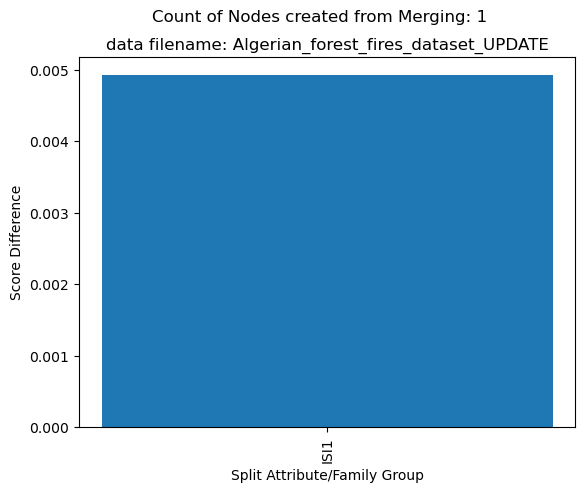

In [114]:
result = filepath.rfind('/')
graph_filepath = filepath[result+1:-4]

family_group = 0
score_list = []
x_labels = []
for family, split_on_attr in zip(children_merged_acc, split_on_list):
    # print(family)
    if max(family) <= 0:
        continue

    family_group +=1
    score_difference = 0
    for individual in family[:-1]:
        score_difference += individual
    score_difference -= family[-1]
    # print(score_difference, split_on_attr)
    score_list.append(score_difference)
    x_labels.append(split_on_attr + str(family_group))

# print("\n",family_group)
# print(score_list)
plt.bar(x=range(family_group), height=score_list, color=mcolors.TABLEAU_COLORS)
plt.xticks(ticks=range(family_group), labels=x_labels)
plt.tick_params(axis='x', rotation=90)
plt.title("data filename: " + graph_filepath)
plt.suptitle("Count of Nodes created from Merging: " + str( len(children_merged_list) ))
plt.xlabel('Split Attribute/Family Group')
plt.ylabel('Score Difference')
str_now = str(dt.datetime.now().strftime("%Y-%m-%d_%H-%M-%S"))
plt.savefig("./images/acc_vs_magnitude_"+graph_filepath +"_"+ str_now+ ".png", bbox_inches="tight")
plt.show()